<center><img src="images/clothing.jpg"></center>

Welcome to the world of e-commerce, where customer feedback is a goldmine of insights! In this project, you'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.

Let's get started!

## Install useful libraries

In [1]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

Defaulting to user installation because normal site-packages is not writeable
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
embedchain 0.1.113 requires chromadb<0.5.0,>=0.4.24, but you have chromadb 0.4.17 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 11.6 MB/s eta 0:00:00ta 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [44]:
# Load the dataset
import pandas as pd

reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [3]:
# Start coding here
# Use as many cells as you need.

Create Embeddings

In [17]:
import uuid
import chromadb


#creating connection to path
client = chromadb.PersistentClient("embeddings")

Create collection

In [48]:
# Creating collection in ChromaDB for storing embeddings if it does not exist
collection = client.get_or_create_collection(
    name="womens_collection",  # Name of the collection
)


Adding to collection

In [49]:
# Add documents (reviews) to the ChromaDB collection
collection.add(
    
    # Generate a unique ID for each review using uuid4
    ids = [str(uuid.uuid4()) for id in reviews["Review ID"]],
    
    # Convert each review text to string (if not already) for storage
    documents = [str(review) for review in reviews["Review Text"]],
)

extracting embeddings from collection

In [50]:
# Retrieve the existing collection named "womens_collection" from ChromaDB
collection = client.get_collection(
    name="womens_collection"
)

# Peek at the first N items in the collection (where N is the number of reviews)
# and extract their embeddings into a pandas DataFrame
embeddings = collection.peek(reviews.shape[0])['embeddings']


Applying dimensionality reduction technique

In [51]:
import pandas as pd
from sklearn.manifold import TSNE

# Initialize t-SNE with 2 output dimensions and perplexity set to half the number of embeddings
tsne = TSNE(random_state=0, n_components=2, perplexity=len(embeddings)/2)

# Convert the embeddings (assumed to be a list or array) into a pandas DataFrame
embeddings_df = pd.DataFrame(embeddings)

# Apply t-SNE to reduce the dimensionality of the embeddings to 2D
embeddings_2d = tsne.fit_transform(embeddings_df)

Visualizing embeddings

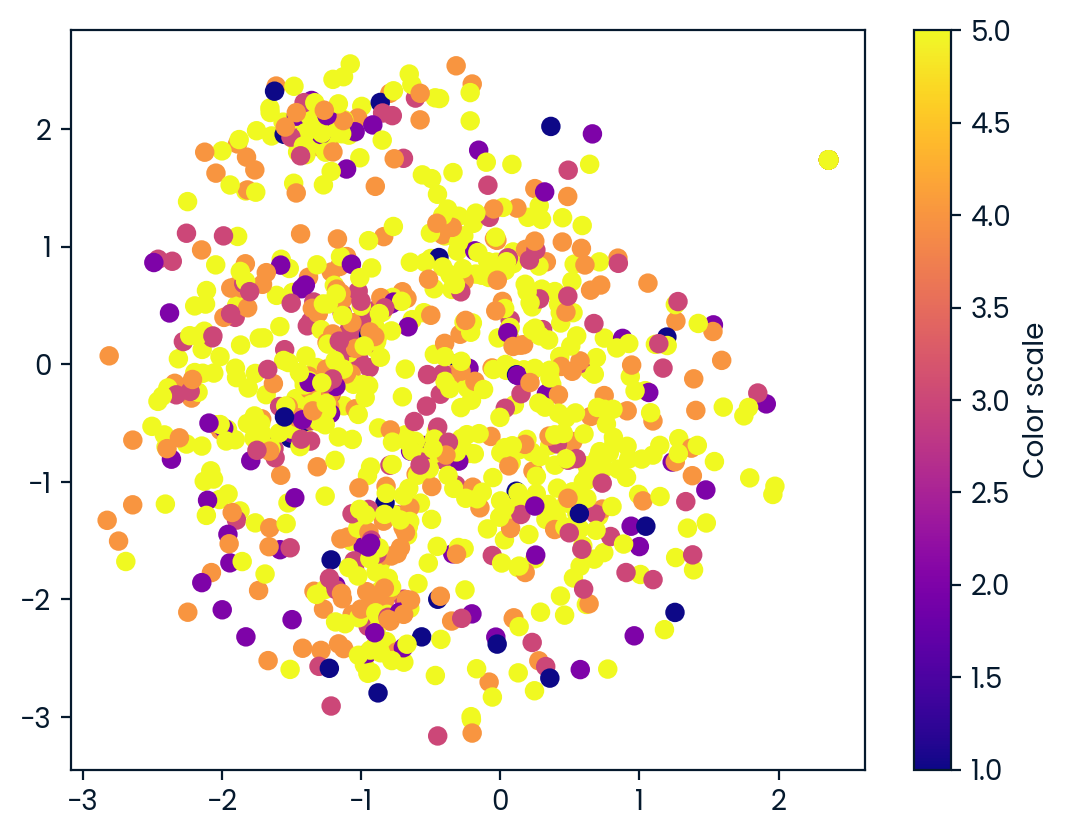

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Use the 'Rating' column from the reviews DataFrame to color the points
colors = reviews["Rating"]

# Create a scatter plot of the 2D embeddings, colored by rating
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=colors, cmap='plasma')

# Add a colorbar to indicate the color scale for ratings
plt.colorbar(label='Color scale')

# Display the plot
plt.show()

Feedback categorization

In [53]:
# Define the feedback categories to search for in the collection
feedback = ['quality', 'fit', 'style', 'comfort']
results = []

# Query the collection for each feedback topic and store the results
for topic in feedback:
    result = collection.query(
        query_texts = topic
    )
    # Append the topic and its associated documents to the results list
    results.append({"topic": topic, "documents": result['documents']})

# Display all comments for each feedback category
for index, topic in enumerate(feedback):
    print(f"comments that spoke on {topic}")
    # Iterate through the documents for the current topic
    for each in results[index]['documents']:
        # Enumerate each comment starting from 1
        stuff = enumerate(each, start=1)
        for index, result in stuff:
            print(f" comment {index} \n {result} \n")

comments that spoke on quality
 comment 1 
 I bought this and like other reviews, agree that the quality probably could be better, but i still love it enough to keep. the buckle fell apart, but i was able to fix it and the zipper seems a little weak. it has pilled, but the fabric is textured, so i didn't even notice until i read the other reviews and then looked back at my jacket.  it is a perfect medium coat for 40's & 50's before i am ready to bust out my ugly down north face for winter.  i get compliments every time i wear it!  love!! 

 comment 2 
 Top of the line! very well made and on sale to boot. i love the style and received a compliment from my sister when i wore it. i love the layered look. 

 comment 3 
 I love the rich deep color and the style but once again this brand runs really small in the waist. i am normally a 8/10 in retailer skirts and the size 10 was tight at the waist enough so i could not button it and feel comfortable. the quality is ok, something i feel i woul

Function to perform similarity search for each input review

In [54]:
# Define a function to find similar comments to a given input comment
def similar_comments(comment, closest=1):
    # Query the collection for the most similar documents to the input comment
    result = collection.query(
        query_texts=comment,
        n_results=closest+1  # Retrieve one extra result (possibly the comment itself)
    )['documents']

    # Return the first set of documents (assuming result is a list of lists)
    return result[0]

# Example comment to search for similar reviews
comment = 'Absolutely wonderful - silky and sexy and comfortable'

# Get the most similar reviews (excluding the first, which may be the comment itself)
most_similar_reviews = similar_comments(comment, closest=3)[1:]

# Iterate through the similar reviews and display them with their index
for index, each in enumerate(most_similar_reviews, start=1):
    print("comment ", index,
          '\n',
          "review - ", each)

comment  1 
 review -  Very comfortable and versatile. got lots of compliments.
comment  2 
 review -  Very cute, very comfortable. for me aesthetics and comfort must go hand in hand. this dress fits the bill.
comment  3 
 review -  Cute and comfortable! i loved the colors and how soft the shirt is!
